# Multinomial logistic regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import mkl

from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation

np.random.seed(1234)
# mkl.set_num_threads(2)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

## Useful imports

In [2]:
from numpy.linalg import inv

## Useful utility functions

In [3]:
def one_hot_encode(labels):
    '''
    Convert label indices into one-hot vectors
    
    Args:
        labels: n-element array with label indices.
    
    Returns:
        n times k matrix where each row is a one-hot encoding
        of a class label. k - number of classes.
    '''
    one_hot = np.zeros((labels.shape[0], max(np.max(labels), 9) + 1), dtype=np.float32)
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot

In [4]:
def draw_params(ax, W):
    '''
    Draw parameters of a multinomial logistic regression in a tiles-like plot.
    
    Args:
        ax:    Axis for plotting.
        W:     Parameters of a multinomial logistic regression model.
               Shape (d+1) times k, where k is the number of classes and
               d is the number of explanatory variables.
    '''
    F = np.reshape(W[:-1, :].T, newshape=(2, -1, 28, 28))
    tiles(ax, F)


def tiles(ax, M):
    '''
    Draw volume M in a tiles-like plot.
    
    Args:
        ax:    Axis for plotting.
        M:     Volume to plot. Shape: r times c times h times w, where
               r is the number of rows in the output plot,
               c is the number of columns in the output plot,
               h is the height of a single tile,
               w is the width of a single tile.
    '''
    rows_count = M.shape[0]
    cols_count = M.shape[1]
    tile_height = M.shape[2]
    tile_width = M.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            ex_min = np.min(M[r, c])
            ex_max = np.max(M[r, c])
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = (M[r, c] - ex_min) / (ex_max - ex_min)
    
    ax.matshow(img_matrix, cmap='gray', interpolation='none')
    ax.axis('off')

## MNIST dataset

In this lab we will use [MNIST handwritten digits dataset](http://yann.lecun.com/exdb/mnist/). Lets import and prepare this dataset.

C:\Users\Olek\AppData\Local\Temp\ipykernel_15888\2097056573.py:6: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))


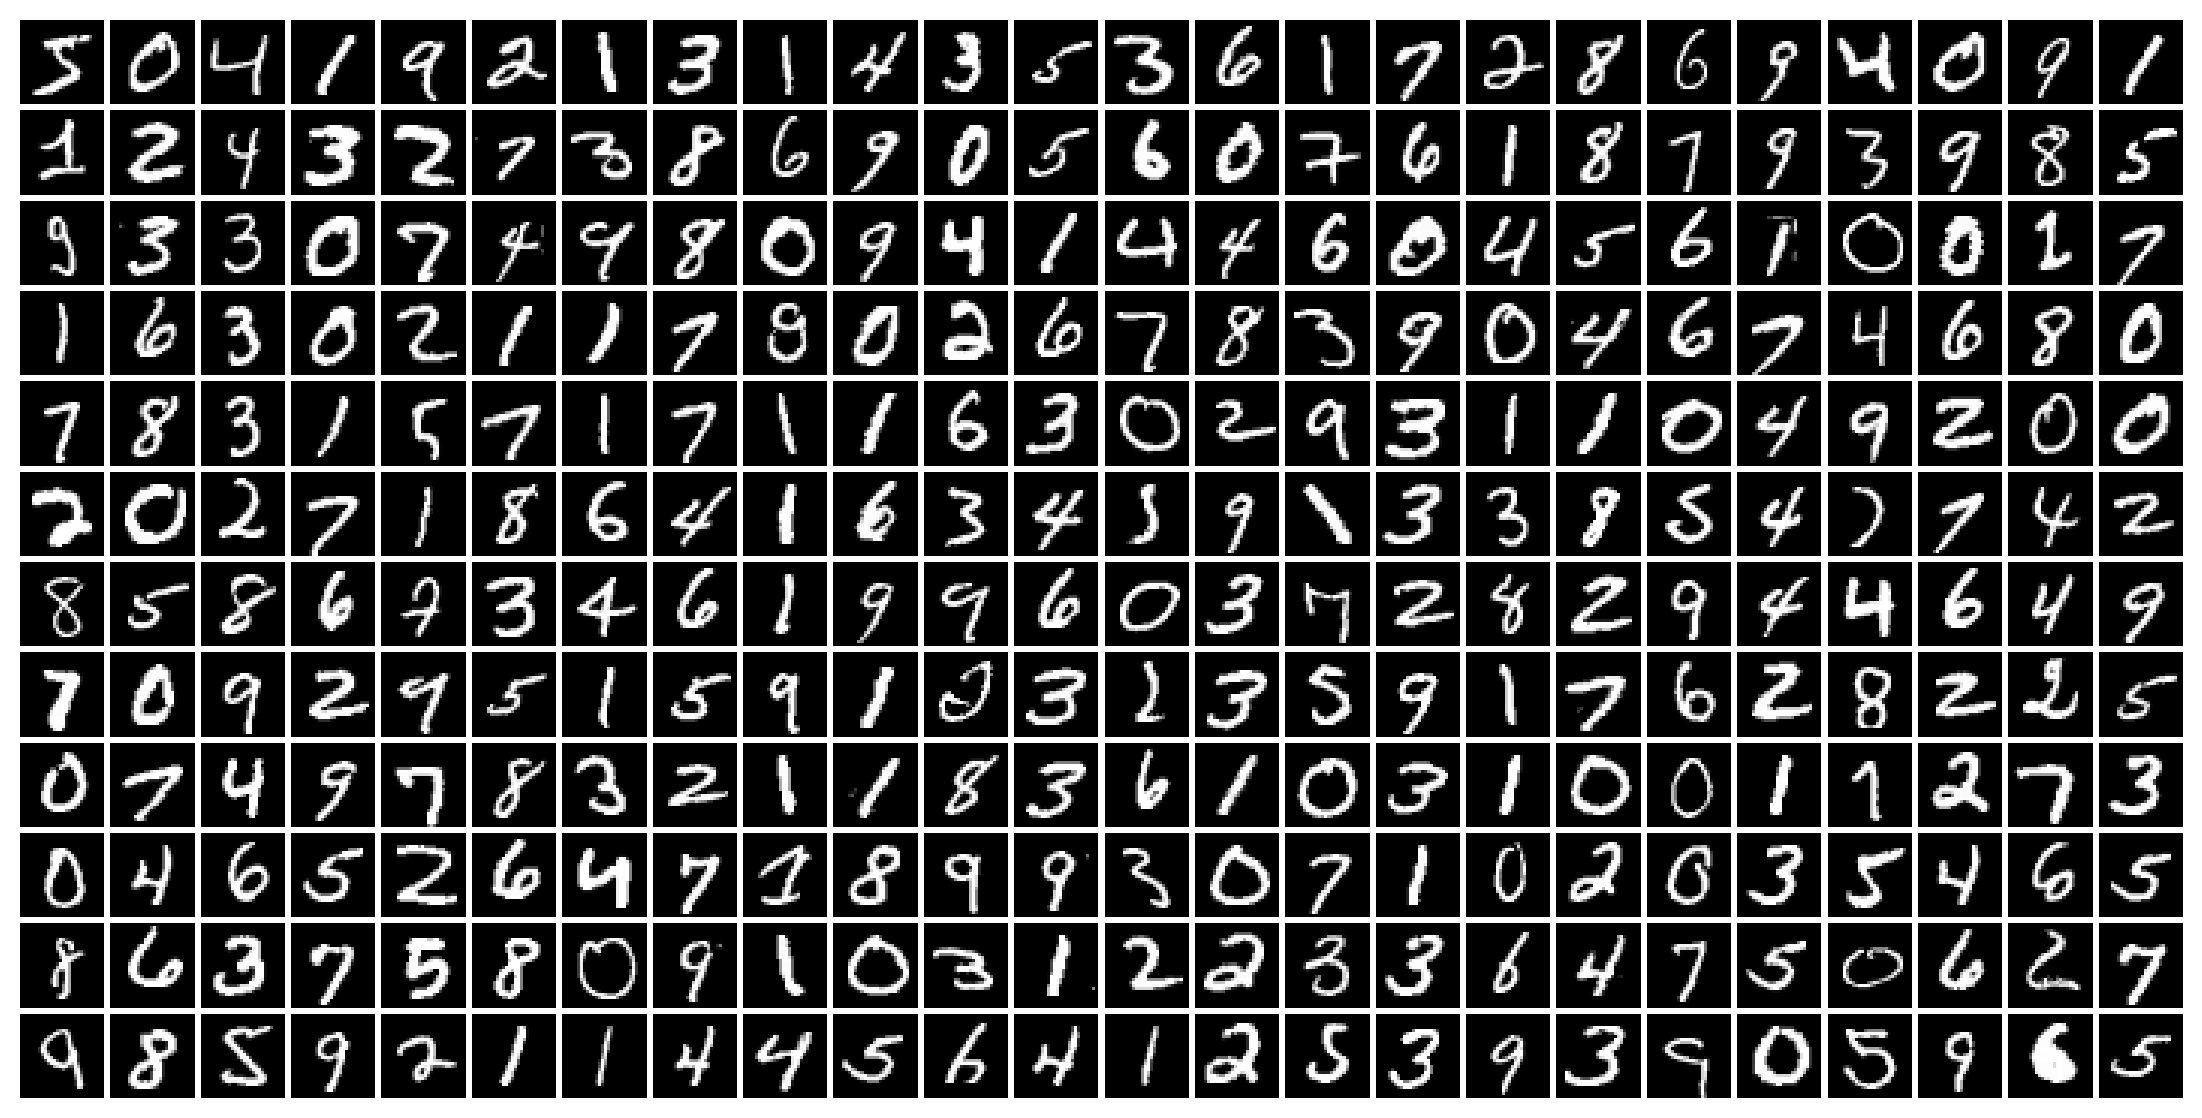

In [5]:
import mnists

mnist = mnists.MNIST()

fig = plt.figure(figsize=(14, 7))
digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
tiles(plt.gca(), digits)

We will reshape each $28 \times 28$ pixel image into a $1 \times 784$ vector and append a fixed $1$ at the end. We will also convert images from $255$ gray levels to $\langle 0, 1 \rangle$ interval. Finally, we will pick a random subset of 20,000 examples for training. The test part of the MNIST dataset will be used for validation.

In [6]:
##### Train set #####

DATASET_SIZE = 20000 # 60000 for whole dataset
DIGIT_SIZE = 28

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_labels = mnist.train_labels()

order = np.random.permutation(len(mnist_train_images))
mnist_train_images = mnist_train_images[order]
mnist_train_labels = mnist_train_labels[order]

mnist_train_images = np.reshape(mnist_train_images[:DATASET_SIZE],
                                newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))

ones = np.ones((mnist_train_images.shape[0], 1))
mnist_train_images = np.concatenate((mnist_train_images, ones), axis=1)

mnist_train_labels = mnist_train_labels[:DATASET_SIZE]
mnist_train_labels = one_hot_encode(mnist_train_labels)

##### Validation set #####

mnist_val_images = mnist.test_images().astype(np.float32) / 255.0
mnist_val_images = np.reshape(mnist_val_images, newshape=(-1, DIGIT_SIZE*DIGIT_SIZE))

ones = np.ones((mnist_val_images.shape[0], 1))
mnist_val_images = np.concatenate((mnist_val_images, ones), axis=1)

mnist_val_labels = mnist.test_labels()
mnist_val_labels = one_hot_encode(mnist_val_labels)

C:\Users\Olek\AppData\Local\Temp\ipykernel_15888\1988988846.py:13: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  mnist_train_images = np.reshape(mnist_train_images[:DATASET_SIZE],
C:\Users\Olek\AppData\Local\Temp\ipykernel_15888\1988988846.py:25: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  mnist_val_images = np.reshape(mnist_val_images, newshape=(-1, DIGIT_SIZE*DIGIT_SIZE))


## Multinomial logistic regression model

Our goal is to fit a multinomial logistic regression model to the MNIST dataset. We start by implementing the link function in this model.

### Softmax link function

Implement `softmax` function which takes an $n \times k$ matrix $\mathbf{Z}$ with class logits and returns an $n \times k$ matrix with categorical probability distributions for observations in $\mathbf{Z}$. The dimensions are: $n$ - number of observations, $k$ - number of classes.

---

**Implementation note**. Imagine that $z_{ij} = 100$. Then in a typical floating-point precision we have:

$$\large
p_{ij} = \frac{\mathrm{e}^{z_{ij}}}{\sum_{l=1}^k \mathrm{e}^{z_{il}}}
       = \frac{\mathrm{e}^{z_{ij}}}{\mathrm{e}^{z_{ij}} + \sum_{\substack{l=1 \\ l \neq j}}^k \mathrm{e}^{z_{il}}}
       = \frac{\mathrm{e}^{100}}{\mathrm{e}^{100} + \sum_{\substack{l=1 \\ l \neq j}}^k \mathrm{e}^{z_{il}}}
       = \frac{\mathrm{inf}}{\mathrm{inf}} = \mathrm{nan}
$$

However, note that for every finite $u \in \mathbb{R}$ we have:

$$\large
p_{ij} = \frac{\mathrm{e}^{z_{ij}}}{\sum_{l=1}^k \mathrm{e}^{z_{il}}}
       = \frac{\mathrm{e}^{-u} \mathrm{e}^{z_{ij}}}{\mathrm{e}^{-u} \sum_{l=1}^k \mathrm{e}^{z_{il}}}
       = \frac{\mathrm{e}^{z_{ij} - u}}{\sum_{l=1}^k \mathrm{e}^{z_{il} - u}}
$$

So to implement `softmax` in a numerically stable manner, we can simply shift the logits (independently for each observation) so that: $\mathop{\mathrm{max}}_{l = 1,\ldots, k} z_{il} = 0$. That is, we set:

$$\large
z_{ij} \leftarrow z_{ij} - \mathop{\mathrm{max}}_{l = 1,\ldots, k} z_{il}
$$

This basically turns an overflow issue into an underflow that we can disregard. Use this trick when implementing `softmax` function.

In [7]:
# we cannot normalize globally - it should be done row by row

def softmax(Z):
    Z_shift = Z - np.max(Z, axis = 1, keepdims = True)
    # axis=1 => sums over rows, returns array (n x 1) - simple column instead of a vector
    E_val = np.exp(Z_shift)

    return E_val / np.sum(E_val, axis = 1, keepdims = True)

### Cost function

Next, we need to implement a cost function for our model and its gradient w.r.t the model parameters. Note that the cross-entropy cost increases proportionally to the number of input observations $n$. This is undesirable from an optimization point of view: the learning rate in gradient descent needs to be adjusted to the number of training observations. To avoid that issue we will calculate an <u>average</u> cross-entropy cost per input observation. That is, we will divide the cross-entropy cost (and therefore also its gradient) by $n$.

---

Implement `xentropy` function which takes as an input:
- An $n \times k$ matrix $\mathbf{S}$ with categorical probability distributions for $n$ input observations.
- An $n \times k$ matrix $\mathbf{T}$ with one-hot encoded class labels for $n$ input observations.

and returns an average (per input observation) cross-entropy between $\mathbf{T}$ and $\mathbf{S}$.



In [8]:
def xentropy(S : np.ndarray, T : np.ndarray):
    n = S.shape[0]
    return -np.sum(T * np.log(S)) / n

Implement `grad_xentropy` function which takes as an input:
- An $n \times (d+1)$ matrix $\mathbf{X}$ with explanatory variables for $n$ input observations.
- An $n \times k$ matrix $\mathbf{S}$ with categorical probability distributions for observations in $\mathbf{X}$.
- An $n \times k$ matrix $\mathbf{T}$ with one-hot encoded class labels for observations in $\mathbf{X}$.

and returns a gradient of the average (per input observation) cross-entropy between $\mathbf{T}$ and $\mathbf{S}$. We assume a standard multinomial logistic regression parametrization:

\begin{align} \large
\mathbf{S}_{ij} & = \frac{\mathrm{e}^{z_{ij}}}{\sum_{l=1}^k \mathrm{e}^{z_{il}}}, \\[1em]
\left[z_{ij}\right]_{n \times k} & = \mathbf{Z} = \mathbf{XW},
\end{align}

and return the gradient w.r.t the model parameters: $\mathbf{W}_{\left(d+1\right) \times k}$.

In [9]:
def grad_xentropy(X : np.ndarray, S : np.ndarray, T : np.ndarray):
    n = S.shape[0]
    return X.T @ (S - T) / n

### Gradient descent training

We are now ready to implement a maximum likelihood estimation for multinomial logistic regression model. We begin with few utility functions.

Implement `classify` function which takes as an input
- An $(d+1) \times k$ matrix $\mathbf{W}$ with parameters of a multinomial logistic regression model.
- An $n \times (d+1)$ matrix $\mathbf{X}$ with explanatory variables for $n$ input observations.

and returns an $n \times k$ NumPy array with predicted class labels in one-hot encoding. We assume that the class predicted for a given observation is the one with the largest probability.

In [10]:
def classify(W, X):
    Z = X @ W # (n x k)
    S = softmax(Z) # (n x k)
    largest_probability_args = np.argmax(S, axis = 1) # (n x 1)

    return one_hot_encode(largest_probability_args) # (n x k)

In [11]:
def calc_acc(P, T):
    '''
    Calculate classification accuracy.
    
    Args:
        P: predicted labels in one-hot encoding,
           shape n times k.
        T: true labels in one-hot encoding,
           shape n times k.           
    
    Returns:
        Percentage of correctly predicted labels.
    '''
    accuracy = np.sum(P * T) / P.shape[0]
    return 100.0 * accuracy


def print_log(step, cost, train_acc, val_acc):
    '''
    A utility function used to display the progress of gd_fit.
    '''
    log = 'Step {:3d}\tcost value: {:5.2f},\ttrain accuracy: {:5.2f},\t' \
          'validation accuracy: {:5.2f}'
    log = log.format(step, cost.item(), train_acc.item(), val_acc.item())
    
    print(log)


We will minimize the cost function with gradient descent. Complete the implementation of `gd_fit` function following comments in the code.

In [12]:
def gd_fit(W0, X, T, X_val, T_val, lr=1.0, steps=100, log_every=5):
    '''
    Fit multinomial logistic regression model with gradient descent.
    
    Args:
        W0:        An array with initial parameter values, shape (d+1) times k.
        X:         An array with explanatory variables for input (train) observations,
                   shape n times (d+1).
        T:         An array with one-hot encoded class labels for input (train) observations, 
                   shape n times k.
        X_val:     An array with explanatory variables for validation observations,
                   shape m times (d+1).
        T_val:     An array with one-hot encoded class labels for validation observations, 
                   shape m times k.
        lr:        Learning rate.
        steps:     Number of gradient descent steps to perform.
        log_every: Number of steps between progress logs.
    
    Returns:
        An (d+1) times k NumPy array with fitted parameters.
    '''
    n = X.shape[0]
    W = np.copy(W0)
    
    for step in range(steps):
        # Assuming that current model parameters are in `W`, calculate the value of
        # the cost function and store it in `cost_val` variable.

        Z = X @ W
        S = softmax(Z)
        
        cost_val = xentropy(S, T)
        
        # Next, calculate the gradient of the cost function w.r.t the parameters
        # in `W`. Use this gradient matrix to update `W` (according to the gradient
        # descent update rule).
        
        W -= lr * grad_xentropy(X, S, T)
        
        
        P_train = classify(W, X)
        train_acc = calc_acc(P_train, T)
        
        P_val = classify(W, X_val)
        val_acc = calc_acc(P_val, T_val)
        
        if step == 0 or (step + 1) % log_every == 0:
            print_log(step+1, cost_val, train_acc, val_acc)
    
    return W

## Fitting multinomial logistic regression model to MNIST.

Lets prepare and plot some initial parameter values.

C:\Users\Olek\AppData\Local\Temp\ipykernel_15888\693860989.py:11: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  F = np.reshape(W[:-1, :].T, newshape=(2, -1, 28, 28))


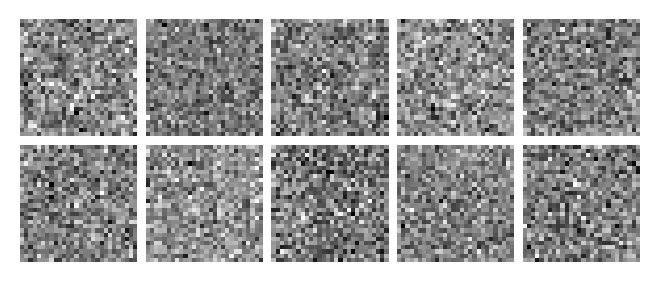

In [13]:
W0 = np.random.randn(DIGIT_SIZE*DIGIT_SIZE + 1, 10)

fig = plt.figure(figsize=(4, 2))
draw_params(plt.gca(), W0)

We can now fit multinomial logistic regression model to the MNIST dataset. Initially we do 200 gradient descent steps starting from `W0`.

In [14]:
W = gd_fit(W0,
           mnist_train_images, mnist_train_labels,
           mnist_val_images, mnist_val_labels,
           lr=3.0, steps=200, log_every=10)

Step   1	cost value: 13.37,	train accuracy: 16.07,	validation accuracy: 15.45
Step  10	cost value:  2.72,	train accuracy: 63.97,	validation accuracy: 64.51
Step  20	cost value:  1.93,	train accuracy: 71.46,	validation accuracy: 71.34
Step  30	cost value:  1.14,	train accuracy: 80.25,	validation accuracy: 80.81
Step  40	cost value:  0.96,	train accuracy: 82.28,	validation accuracy: 82.71
Step  50	cost value:  0.87,	train accuracy: 83.49,	validation accuracy: 83.72
Step  60	cost value:  0.81,	train accuracy: 84.36,	validation accuracy: 84.44
Step  70	cost value:  0.76,	train accuracy: 84.82,	validation accuracy: 84.92
Step  80	cost value:  0.76,	train accuracy: 84.08,	validation accuracy: 84.37
Step  90	cost value:  0.85,	train accuracy: 82.60,	validation accuracy: 82.83
Step 100	cost value:  0.68,	train accuracy: 86.09,	validation accuracy: 86.39
Step 110	cost value:  0.63,	train accuracy: 86.74,	validation accuracy: 86.92
Step 120	cost value:  0.61,	train accuracy: 87.01,	validation ac

Next, we continue with additional 300 steps using a lower learning rate.

In [15]:
W = gd_fit(W,
           mnist_train_images, mnist_train_labels,
           mnist_val_images, mnist_val_labels,
           lr=0.3, steps=300, log_every=25)

Step   1	cost value:  0.50,	train accuracy: 88.92,	validation accuracy: 88.50
Step  25	cost value:  0.50,	train accuracy: 88.94,	validation accuracy: 88.48
Step  50	cost value:  0.49,	train accuracy: 88.95,	validation accuracy: 88.49
Step  75	cost value:  0.49,	train accuracy: 88.96,	validation accuracy: 88.52
Step 100	cost value:  0.49,	train accuracy: 88.97,	validation accuracy: 88.57
Step 125	cost value:  0.49,	train accuracy: 88.99,	validation accuracy: 88.55
Step 150	cost value:  0.48,	train accuracy: 89.03,	validation accuracy: 88.57
Step 175	cost value:  0.48,	train accuracy: 89.03,	validation accuracy: 88.57
Step 200	cost value:  0.48,	train accuracy: 89.07,	validation accuracy: 88.58
Step 225	cost value:  0.48,	train accuracy: 89.09,	validation accuracy: 88.58
Step 250	cost value:  0.48,	train accuracy: 89.12,	validation accuracy: 88.58
Step 275	cost value:  0.47,	train accuracy: 89.13,	validation accuracy: 88.60
Step 300	cost value:  0.47,	train accuracy: 89.16,	validation ac

Let's plot the fitted parameters.

C:\Users\Olek\AppData\Local\Temp\ipykernel_15888\693860989.py:11: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  F = np.reshape(W[:-1, :].T, newshape=(2, -1, 28, 28))


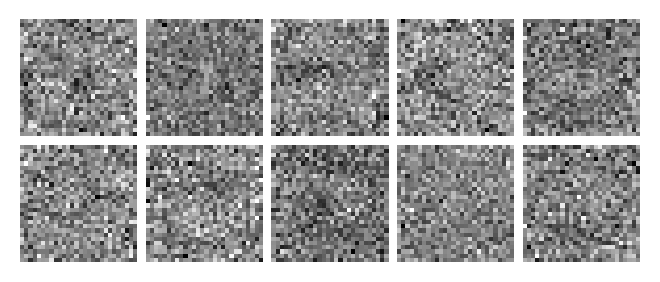

In [16]:
fig = plt.figure(figsize=(4, 2))
draw_params(plt.gca(), W)

## Fitting regularized multinomial logistic regression model to MNIST.

Cross entropy cost function is convex but it is <u>not</u> strictly convex. We can turn it into a strictly convex cost function by adding a regularization term that penalizes magnitudes of model parameters:

$$ \large
\mathcal{L}_R\left(\mathbf{W}\right) = \mathcal{L}\left(\mathbf{W}\right) +
                                       \frac{\lambda}{2}\sum_{i=1}^{d+1}\sum_{j=1}^k w_{ij}^2,
$$

where $\mathcal{L}\left(\mathbf{W}\right)$ is the cross entropy cost.

This is the same regularization that we used in ridge regression, and it can be derived as a MAP estimate in a Bayesian logistic regression model with Gaussian prior on model parameters (we do not need a conjugate prior to find the cost function for a MAP estimate). Let's implement this variant of the logistic regression model.

Complete the implementation of `gd_fit_reg` function following comments in the code.

$$
\frac{\partial}{\partial \mathbf{W}} \mathcal{L}_R(\mathbf{W}) = \frac{\partial}{\partial \mathbf{W}} \mathcal{L}(\mathbf{W}) + \frac{\partial}{\partial \mathbf{W}} \frac{\lambda}{2} \sum_{i=1}^{d+1} \sum_{j=1}^{k} w_{ij}^2
$$

$$
\frac{\partial}{\partial \mathbf{W}} w_{ij}^2 = \frac{\partial}{\partial \mathbf{W}} w_{pq}^2 =
\begin{cases}
0 & \text{if } p \neq i \vee q \neq j \\
2w_{ij} & \text{if } p = i \wedge q = j
\end{cases}
$$

$$
\frac{\partial}{\partial \mathbf{W}} \frac{\lambda}{2} \sum_{i=1}^{d+1} \sum_{j=1}^{k} w_{ij}^2 = 2 \cdot \frac{\lambda}{2} w_{ij} \Big|_{i \in 1,\ldots,n \;\; j \in 1,\ldots,m} = \lambda \mathbf{W}
$$

$$
\frac{\partial}{\partial \mathbf{W}} \mathcal{L}_R(\mathbf{W}) = \frac{\partial}{\partial \mathbf{W}} \mathcal{L}(\mathbf{W}) + \lambda \mathbf{W}
$$

In [17]:
def gd_fit_reg(W0, X, T, X_val, T_val, l2=0.005, lr=1.0, steps=100, log_every=5):
    '''
    Fit multinomial logistic regression model with gradient descent.
    
    Args:
        W0:        An array with initial parameter values, shape (d+1) times k.
        X:         An array with explanatory variables for input (train) observations,
                   shape n times (d+1).
        T:         An array with one-hot encoded class labels for input (train) observations, 
                   shape n times k.
        X_val:     An array with explanatory variables for validation observations,
                   shape m times (d+1).
        T_val:     An array with one-hot encoded class labels for validation observations, 
                   shape m times k.
        l2:        The regularization strength (lambda hyper-paramater).
        lr:        Learning rate.
        steps:     Number of gradient descent steps to perform.
        log_every: Number of steps between progress logs.
    
    Returns:
        An (d+1) times k NumPy array with fitted parameters.
    '''
    n = X.shape[0]
    W = np.copy(W0)
    
    for step in range(steps):
        # Assuming that current model parameters are in `W`, calculate the value of
        # the regularized cost function and store it in `cost_val` variable.
        
        Z = X @ W
        S = softmax(Z)
        
        cost_val = xentropy(S, T) + (l2 / 2) * np.sum(np.square(W))
        
        # Next, calculate the gradient of the regularized cost function w.r.t the
        # parameters in `W`. Use this gradient matrix to update `W` (according to
        # the gradient descent update rule).
        
        W -= lr * (grad_xentropy(X, S, T) + l2 * W)
        
        
        P_train = classify(W, X)
        train_acc = calc_acc(P_train, T)
        
        P_val = classify(W, X_val)
        val_acc = calc_acc(P_val, T_val)
        
        if step == 0 or (step + 1) % log_every == 0:
            print_log(step+1, cost_val, train_acc, val_acc)
    
    return W

Let's fit regularized multinomial logistic regression model to the MNIST dataset.

In [18]:
W_reg = gd_fit_reg(W0,
                   mnist_train_images, mnist_train_labels,
                   mnist_val_images, mnist_val_labels,
                   l2=0.005, lr=3.0,
                   steps=200, log_every=10)

Step   1	cost value: 33.54,	train accuracy: 16.16,	validation accuracy: 15.57
Step  10	cost value: 17.92,	train accuracy: 64.64,	validation accuracy: 64.93
Step  20	cost value: 13.11,	train accuracy: 69.25,	validation accuracy: 69.04
Step  30	cost value:  9.70,	train accuracy: 74.17,	validation accuracy: 73.86
Step  40	cost value:  7.27,	train accuracy: 76.35,	validation accuracy: 76.33
Step  50	cost value:  6.41,	train accuracy: 70.96,	validation accuracy: 70.73
Step  60	cost value:  4.60,	train accuracy: 72.72,	validation accuracy: 72.79
Step  70	cost value:  3.63,	train accuracy: 74.36,	validation accuracy: 74.25
Step  80	cost value:  3.99,	train accuracy: 72.35,	validation accuracy: 72.01
Step  90	cost value:  2.80,	train accuracy: 74.78,	validation accuracy: 74.28
Step 100	cost value:  2.51,	train accuracy: 75.43,	validation accuracy: 75.01
Step 110	cost value:  2.19,	train accuracy: 77.89,	validation accuracy: 77.47
Step 120	cost value:  2.29,	train accuracy: 67.99,	validation ac

In [19]:
W_reg = gd_fit_reg(W_reg,
                   mnist_train_images, mnist_train_labels,
                   mnist_val_images, mnist_val_labels,
                   l2=0.005, lr=0.3,
                   steps=300, log_every=25)

Step   1	cost value:  3.53,	train accuracy: 79.77,	validation accuracy: 80.44
Step  25	cost value:  0.80,	train accuracy: 89.54,	validation accuracy: 90.03
Step  50	cost value:  0.73,	train accuracy: 90.06,	validation accuracy: 90.42
Step  75	cost value:  0.68,	train accuracy: 90.33,	validation accuracy: 90.62
Step 100	cost value:  0.65,	train accuracy: 90.54,	validation accuracy: 90.79
Step 125	cost value:  0.61,	train accuracy: 90.69,	validation accuracy: 91.02
Step 150	cost value:  0.58,	train accuracy: 90.86,	validation accuracy: 91.08
Step 175	cost value:  0.56,	train accuracy: 91.03,	validation accuracy: 91.20
Step 200	cost value:  0.54,	train accuracy: 91.11,	validation accuracy: 91.24
Step 225	cost value:  0.53,	train accuracy: 91.19,	validation accuracy: 91.28
Step 250	cost value:  0.52,	train accuracy: 91.22,	validation accuracy: 91.31
Step 275	cost value:  0.51,	train accuracy: 91.26,	validation accuracy: 91.43
Step 300	cost value:  0.50,	train accuracy: 91.29,	validation ac

Finally we plot the parameters of the regularized model.

C:\Users\Olek\AppData\Local\Temp\ipykernel_15888\693860989.py:11: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  F = np.reshape(W[:-1, :].T, newshape=(2, -1, 28, 28))


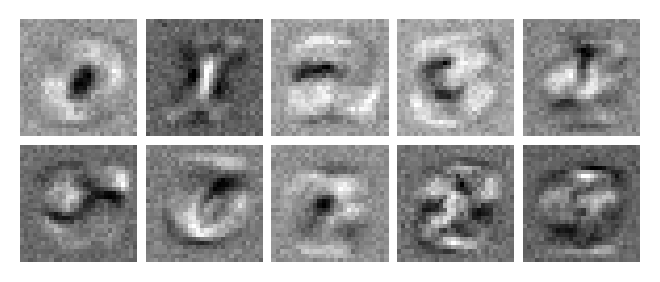

In [20]:
fig = plt.figure(figsize=(4, 2))
draw_params(plt.gca(), W_reg)